# Relationship between Beach Litter Cluster 2 and River Discharge

In [1]:
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from datatree import open_datatree
from sklearn.metrics.pairwise import haversine_distances

sns.set_theme("paper", "darkgrid", "viridis")

## Some Helper Functions

In [2]:
def haversine_distance_degree(latlon1, latlon2):
    latlon1 = np.radians(latlon1)
    latlon2 = np.radians(latlon2)
    return haversine_distances(latlon1, latlon2)


def get_closest_point(lon, lat, lons, lats):
    distances = haversine_distance_degree([[lat, lon]], np.vstack([lats, lons]).T)
    minidx = np.argmin(distances)
    return lons[minidx], lats[minidx]


def lonlat_already_exists(lon, lat, lons, lats, max_distance=10):
    if len(lons) == 0:
        return False
    R = 6371
    distances = haversine_distance_degree([[lat, lon]], np.vstack([lats, lons]).T)
    distances = distances * R
    return np.min(distances) < max_distance


def is_close_to_beach(yx, yx_beach, distance_threshold=250):
    circumference_earth = 40075.0
    distance_threshold = 2 * np.pi * distance_threshold / circumference_earth
    yx = np.deg2rad(yx)
    yx_beach = np.deg2rad(yx_beach)
    distance = haversine_distances(yx, yx_beach)
    return distance < distance_threshold

## Load Data

In [3]:
pca_result = xr.open_dataset(
    "data/clustering/pca/absolute/Plastic/2001/pca_clustering.nc", engine="netcdf4"
)
membership_probability = pca_result.sel(mode=2).confidence_pos

In [4]:
sources = open_datatree("data/litter_sources.zarr", engine="zarr")
results = sources["river"]["discharge_v5"]

River discharge comes with a high spatial resolution showing even tiny creeks. For our anaylsis we assume that tiny creeks are not an important source for macroplastics transport to the ocean. In the following, we consider only rivers with a mean annual discharge of $\geq 10$ $m^3/s$.

In [5]:
results["size"] = results.size.where(results.size > 1)

## Get Coordinates of European Coastline

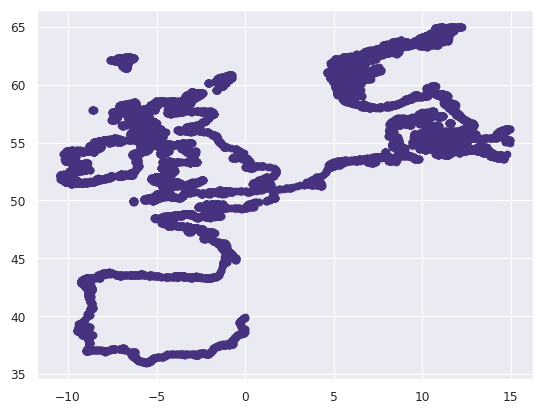

In [6]:
# Extract coastline data for Western Europe
coastline = cfeature.NaturalEarthFeature("physical", "coastline", "10m").geometries()

# Filter for Western Europe coordinates
coastline_coords = []
for geom in coastline:
    if geom.geom_type == "MultiLineString":
        for part in geom.geoms:
            for x, y in part.coords:
                if -12 <= x <= 15 and 36 <= y <= 65 and not (x > 0 and y < 47):
                    coastline_coords.append((x, y))
    else:
        for x, y in geom.coords:
            if -12 <= x <= 15 and 36 <= y <= 65 and not (x > 0 and y < 47):
                coastline_coords.append((x, y))

plt.scatter(*np.vstack(coastline_coords).T)

## Extract Discharge at River Mouths

In [7]:
# Iterate over coastline and get maximum discharge nearby
max_discharge = []
max_seasonal_potential = []

# about 2 km in each direction to find maximum discharge
dx = dy = 0.025

# Keep track of used gridpoints ("river mouths") to avoid double counting
used_lonlats = {"lon": [], "lat": []}
for x, y in coastline_coords:
    # Get a tiny region around each coastline point
    discharge_region = results.sel(lon=slice(x - dx, x + dy), lat=slice(y + dx, y - dy))

    try:
        # Find the maximum discharge
        maxarg = discharge_region.size.argmax(("lon", "lat"))

        # Extract lon and lat of maximum discharge
        xm = discharge_region.size.lon[maxarg["lon"]].item()
        ym = discharge_region.size.lat[maxarg["lat"]].item()

        if lonlat_already_exists(xm, ym, used_lonlats["lon"], used_lonlats["lat"]):
            raise ValueError

        else:
            # Extract maximum discharge and seasonal potential
            dmax = discharge_region.size.isel(lon=maxarg["lon"], lat=maxarg["lat"])
            spmax = discharge_region.seasonal_potential.isel(
                lon=maxarg["lon"], lat=maxarg["lat"]
            )
            used_lonlats["lon"].append(xm)
            used_lonlats["lat"].append(ym)

    except ValueError:
        # If no river mouth is found/river mouth already included
        dmax = np.nan
        spmax = [np.nan, np.nan]

    max_discharge.append(dmax)
    max_seasonal_potential.append(spmax)

max_discharge = np.array(max_discharge)
max_seasonal_potential = np.array(max_seasonal_potential)

Convert the discharge and associated seasonal potential to `DataArrays`:

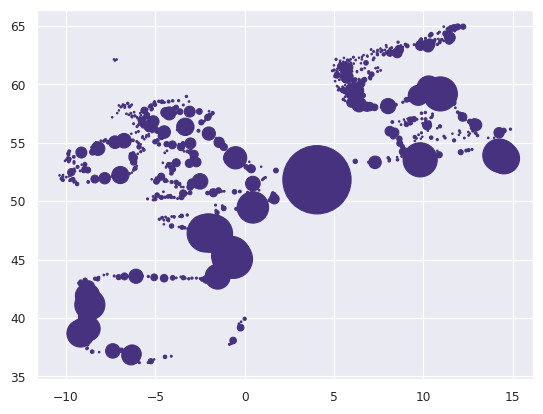

In [8]:
discharge = xr.DataArray(
    max_discharge,
    dims=["discharge"],
    coords={"discharge": max_discharge},
    name="discharge",
)
discharge = discharge.assign_coords(
    lon=("discharge", pd.Index(np.array(coastline_coords).T[0], name="lon"))
)
discharge = discharge.assign_coords(
    lat=("discharge", pd.Index(np.array(coastline_coords).T[1], name="lat"))
)

seasonal_potential = xr.DataArray(
    max_seasonal_potential,
    dims=["discharge", "cluster"],
    coords={"discharge": discharge, "cluster": range(1, 3)},
    name="seasonal_potential",
)
discharge = discharge.sortby("discharge")
seasonal_potential = seasonal_potential.sortby("discharge")

plt.scatter(discharge.lon, discharge.lat, discharge)

Next, we threshold the river discharge depending on the probability of having a relevant OSPAR beach nearby. With relevant we mean that the OSPAR beach is part of cluster 2. We then put all together into a `DataFrame` to simplfiy the plotting procedure using `seaborn`.

In [9]:
lons = discharge.lon
lats = discharge.lat

p_thres = 0.0
beach_ids = membership_probability.beach_id

dist_ths = []
threshold = ["None", 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
for th in threshold:
    if th == "None":
        dist = seasonal_potential.discharge

    else:
        # Filter for beach membership probability; if below threshold, move point far away so it is not considered
        lons_beach = beach_ids.lon.where(membership_probability >= th, -50)
        lats_beach = beach_ids.lat.where(membership_probability >= th, -50)

        yxs = np.vstack([lons, lats]).T
        yxs_beach = np.vstack([lons_beach, lats_beach]).T
        is_valid_beach = is_close_to_beach(yxs, yxs_beach, distance_threshold=200).any(
            axis=1
        )

        dist = seasonal_potential.discharge.isel(discharge=is_valid_beach, drop=True)

    dist = dist.dropna("discharge")
    dist = dist.to_dataframe().reset_index(drop=True)
    dist["threshold"] = th
    dist_ths.append(dist)

dist = pd.concat(dist_ths)

What is the underlying sample size for each PDF?

In [10]:
n_samples = []
for th in threshold:
    sub = dist.discharge[dist.threshold == th]
    n_samples.append(len(sub))
    print("Threshold:", th, "Samples:", len(sub))

# D8ummy data for labels
# columns x; y; threshold, n_samples
# where x,y are just -1 for all threshold
dummy_data = pd.DataFrame(
    {
        "x": [-1] * len(threshold),
        "y": [-1] * len(threshold),
        "threshold": threshold,
        "n_samples": n_samples,
    }
)


Threshold: None Samples: 863
Threshold: 0 Samples: 679
Threshold: 0.05 Samples: 551
Threshold: 0.1 Samples: 486
Threshold: 0.15 Samples: 455
Threshold: 0.2 Samples: 442
Threshold: 0.25 Samples: 376
Threshold: 0.3 Samples: 268
Threshold: 0.35 Samples: 237
Threshold: 0.4 Samples: 47


In [12]:
dist.to_csv("data/physical/river/river_discharge_nea_pdf.csv", index=False)

## Plot PDFs of River Discharge

We estimate PDFs via 

/home/nrieger/miniconda3/envs/basura/lib/python3.10/site-packages/seaborn/_base.py:1156: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  set_scale("log", nonpositive="mask")


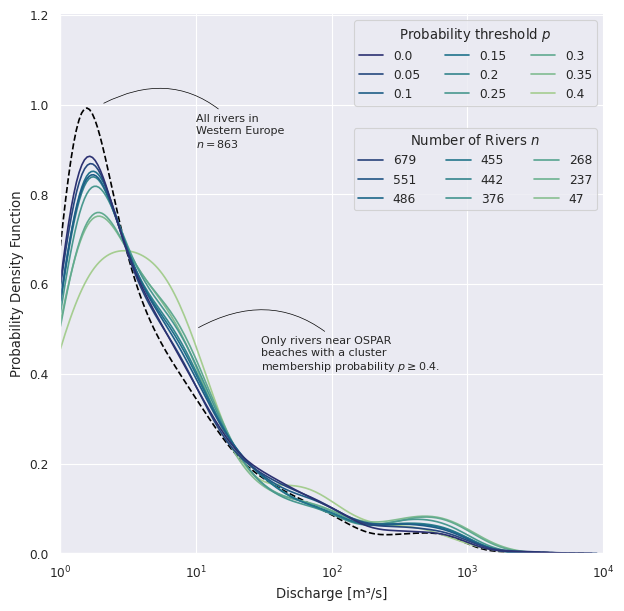

In [ ]:
dist_all_rivers = dist[dist.threshold == "None"]
dist_threshold = dist[dist.threshold != "None"]

plt.figure(figsize=(7, 7))

clrs_crest = sns.color_palette("crest_r", n_colors=len(dummy_data) - 1)

# Add sample sizes
plot_lines = []
dd = dummy_data.iloc[1:].reset_index()
for i, row in dd.iterrows():
    (lp,) = plt.plot(row.x, row.y, color=clrs_crest[i], label=row.n_samples)
    plot_lines.append(lp)
legend1 = plt.legend(
    [pl for pl in plot_lines],
    dd["n_samples"],
    loc="upper right",
    title="Number of Rivers $n$",
    ncol=3,
    bbox_to_anchor=(1.0, 0.8),
    columnspacing=2.5,
)

fg1 = sns.kdeplot(
    data=dist_all_rivers,
    x="discharge",
    log_scale=[True, False],
    common_norm=False,
    clip=[0, None],
    color="k",
    ls="--",
)
fg2 = sns.kdeplot(
    data=dist_threshold,
    x="discharge",
    hue="threshold",
    log_scale=[True, False],
    common_norm=False,
    clip=[0, None],
    palette="crest_r",
)


plt.xlim(1, 10000)
plt.ylim(0, 1.201)
plt.xlabel("Discharge [m³/s]")
plt.ylabel("Probability Density Function")
plt.title("")
sns.move_legend(
    fg2, "upper right", **{"title": "Probability threshold $p$", "ncols": 3}
)

sns.despine(trim=True)

plt.gca().add_artist(legend1)


plt.annotate(
    text=f"All rivers in \nWestern Europe \n$n={n_samples[0]}$",
    xy=(2, 1.0),
    xytext=(10, 0.9),
    xycoords="data",
    ha="left",
    va="bottom",
    fontsize=8,
    arrowprops=dict(
        arrowstyle="-", lw=0.5, color="black", connectionstyle="arc3,rad=.4"
    ),
)
plt.annotate(
    text="Only rivers near OSPAR \nbeaches with a cluster \nmembership probability $p\geq 0.4$.",
    xy=(10, 0.5),
    xytext=(30, 0.4),
    xycoords="data",
    ha="left",
    va="bottom",
    fontsize=8,
    arrowprops=dict(
        arrowstyle="-", lw=0.5, color="black", connectionstyle="arc3,rad=.4"
    ),
)
plt.savefig("figs/figure_supp_river_discharge.png", bbox_inches="tight", dpi=300)
plt.show()